# <img src="./logo_UTN.svg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# TS7: Estimación espectral. Ventanas en acción!

#### Pablo Romero


# Introducción
En este trabajo se consideraron 200 realizaciones por cada ventana analizada en la TS6.
Se graficaron los histogramas para cada caso, se definieron dos estimadores de formas distintas y se compararon sesgo y varianza para cada uno.




In [16]:
# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib as mpl
#%%  Inicialización de librerías
# Setup inline graphics: Esto lo hacemos para que el tamaño de la salida, 
# sea un poco más adecuada al tamaño del documento
mpl.rcParams['figure.figsize'] = (10,10)

from numpy.fft import fft
import matplotlib.pyplot as plt
import scipy.signal as sig


#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi

fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})

##############################################
#%% A partir de aquí comienza lo IMPORTANTE #
#############################################
 
vmax=1       #Amplitud Maxima [Volts]
dc=0            #Valor de continua [Volts]
f0=1 #Frecuencia en [Hz][]
ph=np.pi*1   #Fase [rad]
nn=1000  #Muestras del ADC
fs=1000#Frecuencia de muestreio del ADC [Hz]
k0=nn/4
f0=k0*fs/nn #Frecuencia en [Hz][]         
Ts=1/fs
delta_f=fs/nn
B_bits=4
vf=2
SNRa=25

# cantidad de veces más densa que se supone la grilla temporal para tiempo "continuo"
over_sampling = 4
N_os = nn*over_sampling
fs_os=fs*over_sampling

# datos del ruido


q=vf/2**(B_bits-1)
pot_ruido = np.power(vmax,2)/(2*np.power(10, SNRa/10))

kn = 10
pot_ruido = q**2/12 * kn # Watts (potencia de la señal 1 W)


def mi_funcion_sen(vmax, dc, ff, ph, nn, fs):

    tt = np.arange(0.0, nn/fs, 1/fs)
    aux = tt * 2*np.pi*ff

    xx = (np.sin(2*np.pi*ff*tt+ph))*vmax + dc

    return tt,xx


def Cuantizar (xx, vf, bits):   #Revisar hay algo mal
    
    nn=np.size(xx)
    x = np.zeros(nn)
    delta_q= vf/2**(bits-1)
    # lim_pos = delta_q*((2**(bits-1)-1))
    lim_pos = delta_q*((2**(bits-1)))
    lim_neg = 0-lim_pos
    
    for n in range(nn):
        
        
        x[n]=xx[n]/delta_q
        x[n]=np.round(x[n])
        x[n]=x[n]*delta_q
        if x[n] >= lim_pos:
            x[n]=lim_pos
        elif x[n] <= lim_neg:
            x[n]=lim_neg
            
         
    return x

def discretizar (xx, ov, nn, fs):
    
    x_d = np.zeros(nn)
    tt = np.arange(0.0, nn/fs, 1/fs)
      
    for n in range(nn):
          
        x_d[n]=xx[ov*n]
          
    return tt,x_d




        

Cuantizamos la funcion Sen() y calculoamos el error entre el Sen() y el Sen() cuantizado.

In [17]:
# Funcion para tiempo "continuo"
tt_os, xx_analog = mi_funcion_sen(vmax, dc, f0, ph*0, N_os, fs_os)

#Calculo ruido y lo sumo a la señal
noise_analog = np.random.normal(0,np.sqrt(pot_ruido), N_os)
xx_sn_analog = noise_analog + xx_analog

tt = tt_os[::over_sampling]
xx_d = xx_sn_analog[::over_sampling]

xx_q= Cuantizar(xx_d, vf, B_bits)
noise_digital=xx_q-xx_d

Hago las transformadas fft de las distintas señales.

In [18]:
ff= np.arange(0.0, fs, fs/nn)
ff_os= np.arange(0.0, fs_os, fs_os/ N_os )

ft_xx_analog=fft(xx_analog)
ft_xx=fft(xx_d)
ft_xx_q=fft(xx_q)

N_analog=fft(noise_analog)
N_digital=fft(noise_digital)


Cuantizacion para ADC de 4 bits y Kn=1

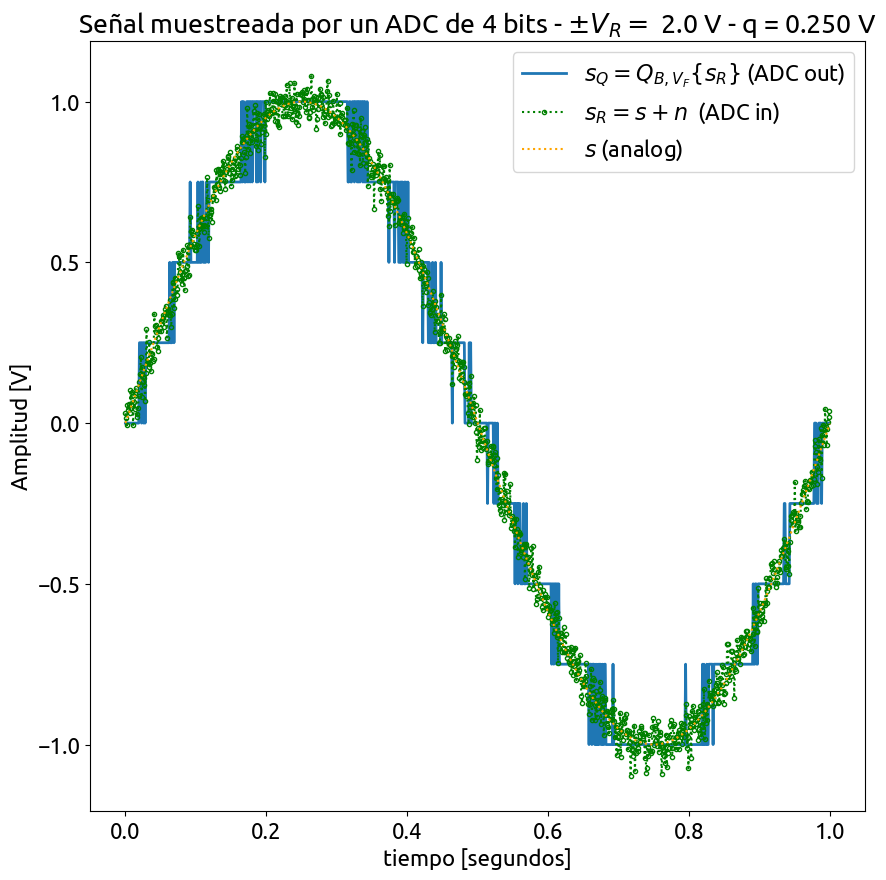

In [7]:
plt.figure(1)
plt.clf()
plt.plot(tt, xx_q, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(tt, xx_d, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, xx_analog, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B_bits, vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

Espectro en db

(-100.32767783370869, 10)

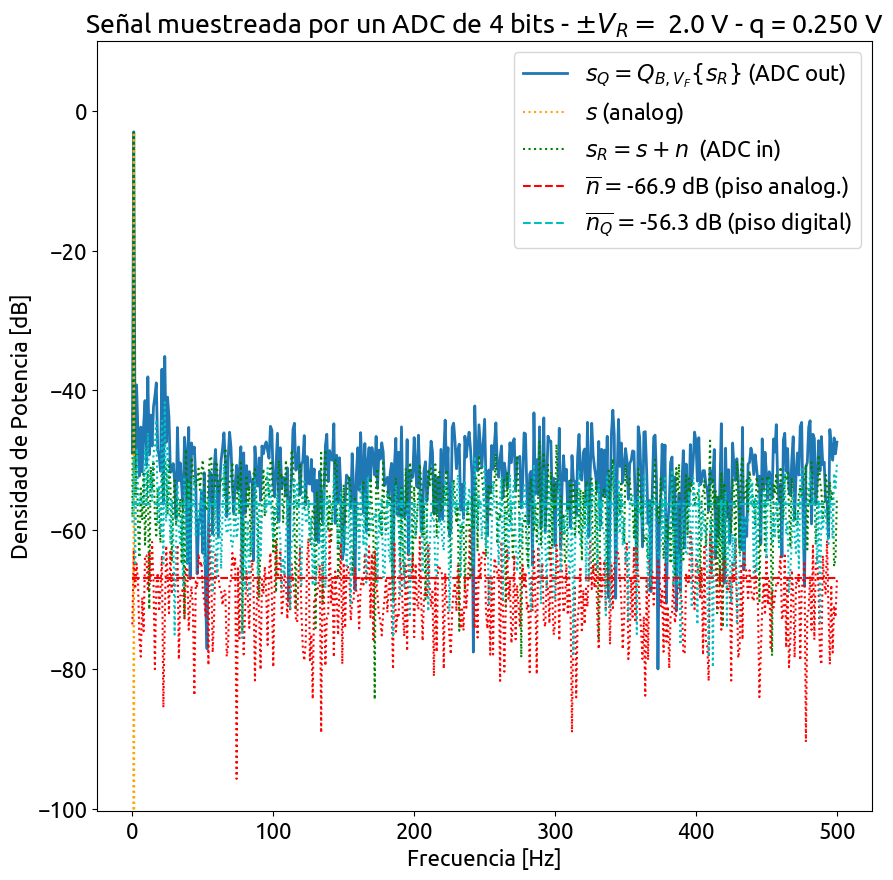

In [8]:
plt.figure(2)
plt.clf()
bfrec = ff <= fs/2
bfrec_os = ff_os <= fs/2

 
Nnq_mean = np.mean(np.abs(N_digital*1/(2*nn))**2)
# Nnq_mean = np.mean((1/(N_os)*np.abs(ft_xx_analog))**2)
nNn_mean = np.mean(np.abs(N_analog*1/(2*N_os))**2)
 
plt.plot( ff[bfrec], 10* np.log10((2*np.abs(ft_xx_q[bfrec]*1/(nn))**2)), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10((2*np.abs(ft_xx_analog[ff_os <= fs/2]*1/(N_os))**2)) , color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10((2*np.abs(ft_xx[bfrec]*1/(nn))**2)), ':g', label='$ s_R = s + n $  (ADC in)' )

plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(N_analog[ff_os <= fs/2]*1/(2*N_os))**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(N_digital[bfrec]*1/(2*nn))**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2*np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2*nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2*np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2*Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B_bits, vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))

Histograma

Text(0.5, 1.0, 'Ruido de cuantización para 4 bits - V_R=2.0 V - q = 0.250 V')

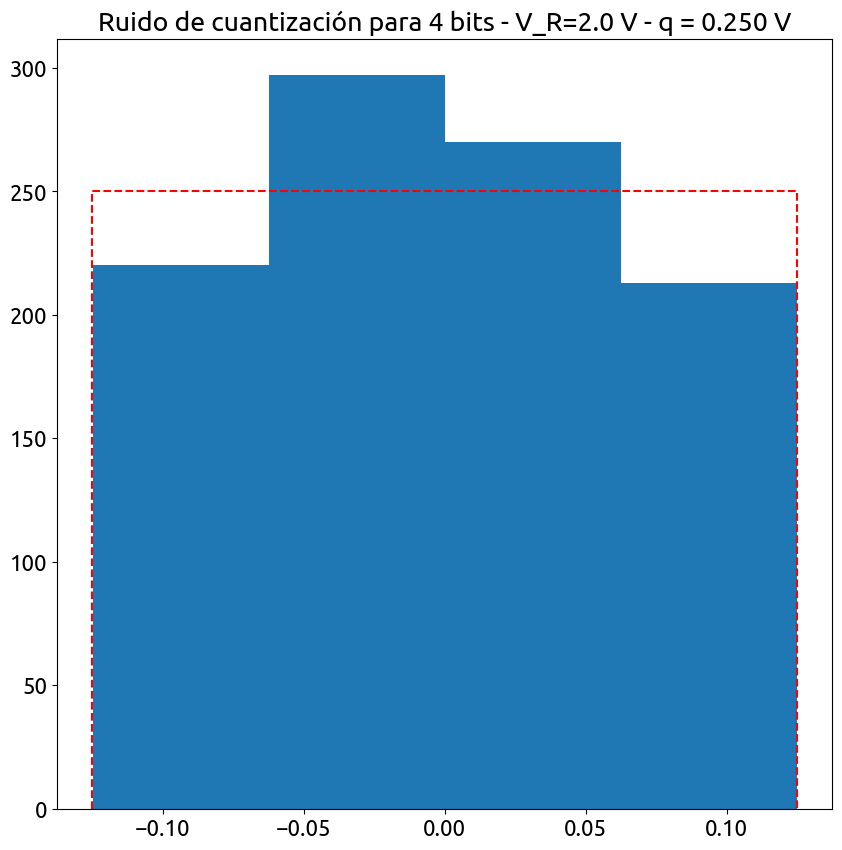

In [10]:
plt.figure(3)
bins = B_bits
plt.hist(noise_digital, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, nn/bins, nn/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - V_R={:3.1f} V - q = {:3.3f} V'.format(4, vf, q))

In [ ]:
Variando Bits y Kn, vemos que hay casos donde el ruido digital es mayor al analogico y viceversa. En este caso 8 bits yt Kn=10

(-120.09824979616772, 10)

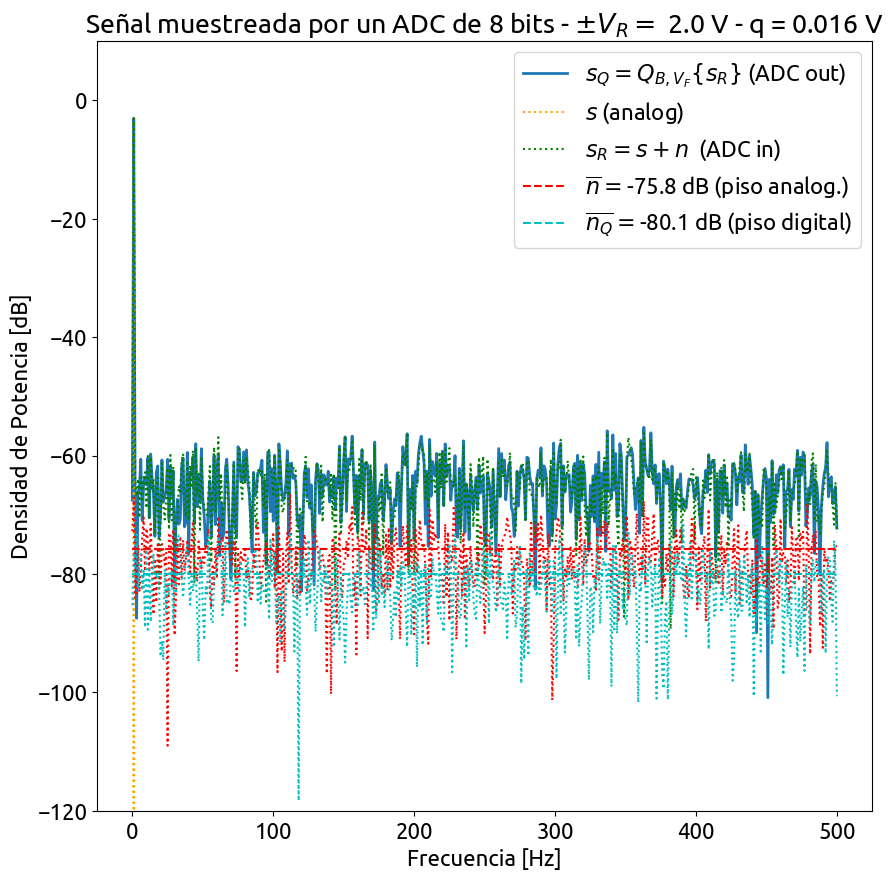

In [19]:
plt.figure(4)
plt.clf()
bfrec = ff <= fs/2
bfrec_os = ff_os <= fs/2

 
Nnq_mean = np.mean(np.abs(N_digital*1/(2*nn))**2)
# Nnq_mean = np.mean((1/(N_os)*np.abs(ft_xx_analog))**2)
nNn_mean = np.mean(np.abs(N_analog*1/(2*N_os))**2)
 
plt.plot( ff[bfrec], 10* np.log10((2*np.abs(ft_xx_q[bfrec]*1/(nn))**2)), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10((2*np.abs(ft_xx_analog[ff_os <= fs/2]*1/(N_os))**2)) , color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10((2*np.abs(ft_xx[bfrec]*1/(nn))**2)), ':g', label='$ s_R = s + n $  (ADC in)' )

plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(N_analog[ff_os <= fs/2]*1/(2*N_os))**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(N_digital[bfrec]*1/(2*nn))**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2*np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2*nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2*np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2*Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B_bits, vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))



Fin del documento